In [74]:
import pandas as pd
import pickle
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import eli5
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,TimeSeriesSplit
import warnings
from IPython.display import display_html
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
def site_sparse_matrix(path_to_train, path_to_test, pickle_file, vector_params):
    
    # all site columns
    sites = ['site%d' %i for i in range(1,11)]
    times = ['time%d' %i for i in range(1,11)]
    
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    train_df = train_df.sort_values(by='time1')
    # clean data 
    train_df[sites] = train_df[sites].fillna(0).astype('int')
    test_df[sites] = test_df[sites].fillna(0).astype('int')

    
    with open(pickle_file,'rb') as input_file:
        site_id_dict = pickle.load(input_file)
    
    site_map={}
    for _name in site_id_dict:
        site_map[site_id_dict[_name]] = _name
    
    site_map[0]='unknown'

    #convert site id -> site name
    # it will help us to analysis after EDA
    # pd.dataframe .apply (axis=1) mean process each row
    train_session = train_df[sites].apply(lambda row: ' '.join([site_map[i] for i in row]), axis=1).tolist()
    test_session = test_df[sites].apply(lambda row: ' '.join([site_map[i] for i in row]), axis=1).tolist()
    
    # have word list now process bag of word 
    vectorizer = TfidfVectorizer(**vector_params)
    X_train = vectorizer.fit_transform(train_session)
    X_test = vectorizer.transform(test_session)
    y_train = train_df['target'].astype('int').values
    train_times = train_df[times]
    test_times = test_df[times]
    
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
    

In [3]:
# prepare site sparse matrix
train_session, test_session, y_train, tfv, train_times, test_times = site_sparse_matrix('train_sessions.csv','test_sessions.csv','site_dic.pkl',
                                                                                       vector_params={'ngram_range':(1,5),'max_features':50000,'tokenizer':lambda s: s.split(" ")})             

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score,TimeSeriesSplit

logit = LogisticRegression(C=1.0, random_state=17, solver='liblinear', max_iter=100, n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
time_split = TimeSeriesSplit(n_splits=10)
cv_scores1 = cross_val_score(logit, train_session, y_train, cv=skf, 
                            scoring='roc_auc', n_jobs=4)
print(cv_scores1)
logit.fit(train_session, y_train)
eli5.show_weights(estimator=logit, feature_names=tfv.get_feature_names(), top=30)

[0.95536723 0.950069   0.95015396 0.95351103 0.95363514]


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [5]:
# Time feature EDA
import seaborn as sns
from scipy.sparse import hstack

session_start_time = train_times['time1'].apply(lambda ts: ts.hour).values

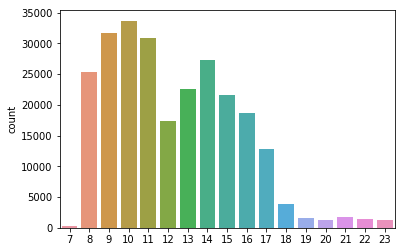

In [6]:
sns.countplot(session_start_time)

Text(0.5, 1.0, 'Alice')

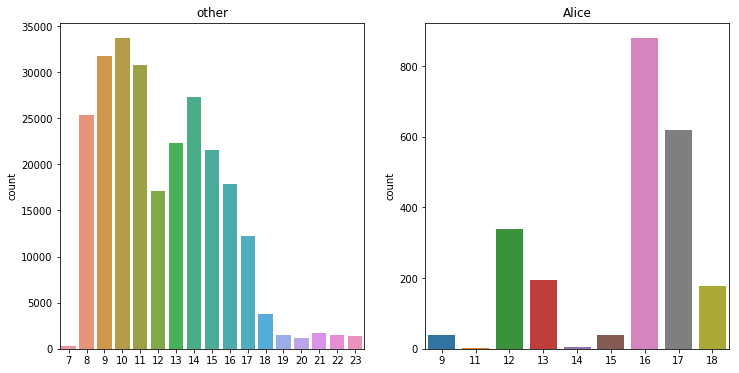

In [7]:
other_start_time = session_start_time[y_train==0]
alice_start_time = session_start_time[y_train==1]
_, ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(other_start_time,ax=ax[0]).set_title('other')
sns.countplot(alice_start_time,ax=ax[1]).set_title('Alice')
# other people mainly start at morning 
# Alice mainly focus on lunch time and 16-18

In [8]:
# make four categories
morning = ((session_start_time>=7)&(session_start_time<=11)).astype('int')
day = ((session_start_time>=12)&(session_start_time<=18)).astype('int')
evening = ((session_start_time>=19)&(session_start_time<=23)).astype('int')
night = ((session_start_time>=0)&(session_start_time<=6)).astype('int')

scaling_start_hour = session_start_time/24

In [9]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

In [10]:
def add_start_time_feature(X_train, X_train_time, add_hour=True):
    session_start_time = X_train_time['time1'].apply(lambda ts: ts.hour)
    morning = ((session_start_time>=7)&(session_start_time<=11)).astype('int').values.reshape(-1,1)
    day = ((session_start_time>=12)&(session_start_time<=18)).astype('int').values.reshape(-1,1)
    evening = ((session_start_time>=19)&(session_start_time<=23)).astype('int').values.reshape(-1,1)
    night = ((session_start_time>=0)&(session_start_time<=6)).astype('int').values.reshape(-1,1)
    # np.hstack make should each array should have same dim
    # practice how to merge certain array together
    all_features = [X_train, morning, day, evening, night]
    time_features = ['morning','day','evening','night']
    if add_hour:
        scaling_start_hour = session_start_time/24
        scaling_start_hour = scaling_start_hour.values.reshape(-1,1)
        all_features.append(scaling_start_hour) # don't use a = [a,b] it will make a sublist 
        time_features.append('start_hour_rescale')
    
    all_features = hstack(all_features)
    return all_features, time_features
    
    

In [11]:
# train new model after adding start time feature
new_train_feat_whour, new_features1= add_start_time_feature(train_session, train_times)
new_test_feat_whour, _ = add_start_time_feature(test_session, test_times)
new_train_feat_nohour, new_features2 = add_start_time_feature(train_session, train_times, False)
new_test_feat_nohour, _ = add_start_time_feature(test_session, test_times, False)


In [12]:
def train_and_predict(model, X_train, y_train, X_test, site_features=tfv.get_feature_names(), new_feature_names=None,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv'):
    
    cv_score = cross_val_score(model, X_train, y_train, cv=time_split, scoring=scoring, n_jobs=-1)
    print('CV ROC Score->{} \r mean: {}, std: {}'.format(cv_score,np.mean(cv_score), np.std(cv_score)))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_features + new_feature_names
    else:
        all_feature_names = site_features
    
    display_html(eli5.show_weights(estimator=model, feature_names=all_feature_names, top=top_n_features))
    
    test_pred = model.predict_proba(X_test)[:,-1]
    write_to_submission_file(test_pred, out_file=submission_file)
    
    return cv_score

In [13]:
# with hour value
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat1 = train_and_predict(logit_new, new_train_feat_whour, y_train, new_test_feat_whour, site_features=tfv.get_feature_names(), new_feature_names=new_features1,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission2.csv')

CV ROC Score->[0.81904687 0.78705941 0.94510729 0.96676436 0.88993687 0.96695898
 mean: 0.9167576893172427, std: 0.06210632157468878


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+7.046,start_hour_rescale
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.986,www.express.co.uk
+4.833,youwatch.org
+4.804,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


In [14]:
pd.DataFrame({'new_feat': new_features1, 'coef': logit_new.coef_[0][-len(new_features1):]})

,new_feat,coef
0,morning,-2.904833
1,day,-0.613841
2,evening,-5.069779
3,night,0.000000
4,start_hour_rescale,7.045650


In [15]:
# without hour value
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat2 = train_and_predict(logit_new, new_train_feat_nohour, y_train, new_test_feat_nohour, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission3.csv')


CV ROC Score->[0.88170019 0.81426901 0.91861247 0.96171465 0.91532998 0.95227476
 mean: 0.9211539394820711, std: 0.04206422641352535


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


In [16]:
pd.DataFrame({'new_feat': new_features2, 'coef': logit_new.coef_[0][-len(new_features2):]})

,new_feat,coef
0,morning,-3.211819
1,day,0.526636
2,evening,-2.721465
3,night,0.000000


In [17]:
# add duration time into feature
durTime_train = (train_times.max(axis=1)-train_times.min(axis=1)).astype('timedelta64[s]').astype(int).values.reshape(-1,1)
durTime_test = (test_times.max(axis=1)-test_times.min(axis=1)).astype('timedelta64[s]').astype(int).values.reshape(-1,1)

scaler = StandardScaler()
durTime_train = scaler.fit_transform(durTime_train)
durTime_test = scaler.transform(durTime_test)

new_train_wdur = hstack([new_train_feat_nohour, durTime_train])
new_test_wdur = hstack([new_test_feat_nohour, durTime_test])

if 'duration time' not in new_features2:
    new_features2.append('duration time')

C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_start_time_feat3 = train_and_predict(logit_new, new_train_wdur, y_train, new_test_wdur, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission4.csv')


CV ROC Score->[0.86809822 0.81821851 0.91950263 0.96171682 0.91593618 0.95368736
 mean: 0.9210072395169003, std: 0.04287807604836511


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.974,vk.com
+4.969,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.532,www.info-jeunes.net
+4.363,www.melty.fr
+4.148,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


## Add YMD as numerical features into model
### 95.35%

In [19]:
## add Y/M/D 
scaler = StandardScaler()
train_weekday_feat = train_times['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
train_yearmonth_feat = (train_times['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
train_month_feat = train_times['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)


test_weekday_feat = test_times['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
test_yearmonth_feat = (test_times['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
test_month_feat = test_times['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)


In [20]:
# train_weekday_feat = scaler.fit_transform(train_weekday_feat)
train_yearmonth_feat = scaler.fit_transform(train_yearmonth_feat)
# train_month_feat = scaler.fit_transform(train_month_feat)

# test_weekday_feat = scaler.transform(test_weekday_feat)
test_yearmonth_feat = scaler.transform(test_yearmonth_feat)
# test_month_feat = scaler.transform(test_month_feat)

new_train_addYMD = hstack([new_train_wdur, train_weekday_feat, train_yearmonth_feat, train_month_feat])
new_test_addYMD = hstack([new_test_wdur, test_weekday_feat, test_yearmonth_feat, test_month_feat])


In [21]:
new_features2 = new_features2[:5]
new_features2+=['weekday', 'yearmonth','month']

In [22]:
logit_new = LogisticRegression(C=4.6415, penalty='l2' ,random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_YMD_feat = train_and_predict(logit_new, new_train_addYMD, y_train, new_test_addYMD, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv')


CV ROC Score->[0.78764245 0.79651133 0.94990119 0.97234163 0.9196626  0.95721145
 mean: 0.9203884143314849, std: 0.06563361972305161


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+11.615,www.express.co.uk
+11.270,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.832,tru.am
+7.170,browser-update.org
+6.472,fr.glee.wikia.com
+6.294,www.banque-chalus.fr
+6.271,api.bing.com
+6.116,glee.hypnoweb.net
+5.962,mcetv.fr
+5.812,www.springboardplatform.com


In [23]:
pd.DataFrame({'feat_name': new_features2, 'coef': logit_new.coef_[0][-len(new_features2):]})

,feat_name,coef
0,morning,-3.164513
1,day,0.765722
2,evening,-3.692111
3,night,0.000000
4,duration time,-0.202630
5,weekday,-0.397970
6,yearmonth,-0.410162
7,month,0.043842


### Right now this logitics model has best performance, save this sparse data

In [102]:
from scipy import sparse

y = y_train.reshape(-1,1)
train_session_npz = hstack([new_train_addYMD, y])
test_session_npz = new_test_addYMD

sparse.save_npz('train_session.npz', train_session_npz)
sparse.save_npz('test_session.npz', test_session_npz)

### Grid Search fine tuning for Xgboost 

In [57]:
m = new_train_addYMD.tocsr()
n = new_test_addYMD.tocsr()

xgb_train = m[:int(new_train_addYMD.shape[0]*0.8),:]
xgb_train_y = y_train[:int(y_train.shape[0]*0.8)]

xgb_test = m[int(new_train_addYMD.shape[0]*0.8):,:]
xgb_test_y = y_train[int(y_train.shape[0]*0.8):]

eval_set = [(xgb_train,xgb_train_y),(xgb_test, xgb_test_y)]

In [28]:
# first let's see how much iteration(# of trees) we need for model

eval_metric = ['auc', 'error']
model = XGBClassifier(slient=False,
                     scale_pos_weight=1,
                     learning_rate=0.01,
                     colsample_bytree=0.4,
                     subsample=0.8,
                     objective='binary:logistic',
                     n_estimators=1000,
                     reg_alpha=0.3,
                     max_depth=4,
                     gamma=10)


#### decide the number of tree (n_estimators), first fix params of tree structure and fix learning_rate in a high value(0.1) 

In [60]:
%time
model.fit(new_train_addYMD, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

Wall time: 0 ns
[0]	validation_0-auc:0.677147	validation_0-error:0.009441	validation_1-auc:0.646088	validation_1-error:0.00629
[1]	validation_0-auc:0.708712	validation_0-error:0.009352	validation_1-auc:0.672415	validation_1-error:0.00631
[2]	validation_0-auc:0.731216	validation_0-error:0.008627	validation_1-auc:0.69538	validation_1-error:0.006389
[3]	validation_0-auc:0.742067	validation_0-error:0.008652	validation_1-auc:0.705017	validation_1-error:0.00633
[4]	validation_0-auc:0.741873	validation_0-error:0.008667	validation_1-auc:0.704865	validation_1-error:0.006389
[5]	validation_0-auc:0.741868	validation_0-error:0.008652	validation_1-auc:0.704827	validation_1-error:0.006369
[6]	validation_0-auc:0.749725	validation_0-error:0.00951	validation_1-auc:0.707504	validation_1-error:0.006369
[7]	validation_0-auc:0.748653	validation_0-error:0.009662	validation_1-auc:0.706613	validation_1-error:0.006369
[8]	validation_0-auc:0.753452	validation_0-error:0.009677	validation_1-auc:0.708064	validatio

[73]	validation_0-auc:0.871236	validation_0-error:0.009608	validation_1-auc:0.843468	validation_1-error:0.006389
[74]	validation_0-auc:0.87119	validation_0-error:0.009608	validation_1-auc:0.843425	validation_1-error:0.006389
[75]	validation_0-auc:0.87117	validation_0-error:0.009603	validation_1-auc:0.843421	validation_1-error:0.006389
[76]	validation_0-auc:0.871201	validation_0-error:0.009608	validation_1-auc:0.843512	validation_1-error:0.006389
[77]	validation_0-auc:0.871175	validation_0-error:0.009608	validation_1-auc:0.843494	validation_1-error:0.006389
[78]	validation_0-auc:0.87118	validation_0-error:0.009608	validation_1-auc:0.843476	validation_1-error:0.006389
[79]	validation_0-auc:0.87123	validation_0-error:0.009608	validation_1-auc:0.843515	validation_1-error:0.006389
[80]	validation_0-auc:0.871203	validation_0-error:0.009603	validation_1-auc:0.843481	validation_1-error:0.006389
[81]	validation_0-auc:0.871208	validation_0-error:0.009603	validation_1-auc:0.843486	validation_1-er

[146]	validation_0-auc:0.879441	validation_0-error:0.009066	validation_1-auc:0.85754	validation_1-error:0.006369
[147]	validation_0-auc:0.87978	validation_0-error:0.009066	validation_1-auc:0.857952	validation_1-error:0.006369
[148]	validation_0-auc:0.880943	validation_0-error:0.009051	validation_1-auc:0.859151	validation_1-error:0.006369
[149]	validation_0-auc:0.880941	validation_0-error:0.009046	validation_1-auc:0.859118	validation_1-error:0.006369
[150]	validation_0-auc:0.881176	validation_0-error:0.009056	validation_1-auc:0.859225	validation_1-error:0.006369
[151]	validation_0-auc:0.881164	validation_0-error:0.009051	validation_1-auc:0.859939	validation_1-error:0.006369
[152]	validation_0-auc:0.881434	validation_0-error:0.008982	validation_1-auc:0.860358	validation_1-error:0.006369
[153]	validation_0-auc:0.881833	validation_0-error:0.008721	validation_1-auc:0.860802	validation_1-error:0.006369
[154]	validation_0-auc:0.881847	validation_0-error:0.00879	validation_1-auc:0.860816	valid

[219]	validation_0-auc:0.918281	validation_0-error:0.008593	validation_1-auc:0.916527	validation_1-error:0.006369
[220]	validation_0-auc:0.918409	validation_0-error:0.008598	validation_1-auc:0.916785	validation_1-error:0.006369
[221]	validation_0-auc:0.91845	validation_0-error:0.008602	validation_1-auc:0.916972	validation_1-error:0.006369
[222]	validation_0-auc:0.918503	validation_0-error:0.008598	validation_1-auc:0.91711	validation_1-error:0.006369
[223]	validation_0-auc:0.918547	validation_0-error:0.008583	validation_1-auc:0.917213	validation_1-error:0.006369
[224]	validation_0-auc:0.918454	validation_0-error:0.008578	validation_1-auc:0.91713	validation_1-error:0.006369
[225]	validation_0-auc:0.918378	validation_0-error:0.008588	validation_1-auc:0.917075	validation_1-error:0.006369
[226]	validation_0-auc:0.918409	validation_0-error:0.008573	validation_1-auc:0.917163	validation_1-error:0.006369
[227]	validation_0-auc:0.918362	validation_0-error:0.008573	validation_1-auc:0.927667	valid

[292]	validation_0-auc:0.93075	validation_0-error:0.008489	validation_1-auc:0.942698	validation_1-error:0.006251
[293]	validation_0-auc:0.930759	validation_0-error:0.008474	validation_1-auc:0.942697	validation_1-error:0.006251
[294]	validation_0-auc:0.931498	validation_0-error:0.008484	validation_1-auc:0.942747	validation_1-error:0.006271
[295]	validation_0-auc:0.931524	validation_0-error:0.008479	validation_1-auc:0.942849	validation_1-error:0.006251
[296]	validation_0-auc:0.931525	validation_0-error:0.008464	validation_1-auc:0.942895	validation_1-error:0.006251
[297]	validation_0-auc:0.931635	validation_0-error:0.00846	validation_1-auc:0.943723	validation_1-error:0.006271
[298]	validation_0-auc:0.931563	validation_0-error:0.00845	validation_1-auc:0.943646	validation_1-error:0.006271
[299]	validation_0-auc:0.931592	validation_0-error:0.008445	validation_1-auc:0.943648	validation_1-error:0.006271
[300]	validation_0-auc:0.933823	validation_0-error:0.008435	validation_1-auc:0.943744	valid

[365]	validation_0-auc:0.94302	validation_0-error:0.008366	validation_1-auc:0.951355	validation_1-error:0.006093
[366]	validation_0-auc:0.942976	validation_0-error:0.008366	validation_1-auc:0.95131	validation_1-error:0.006093
[367]	validation_0-auc:0.942935	validation_0-error:0.008366	validation_1-auc:0.951286	validation_1-error:0.006113
[368]	validation_0-auc:0.942932	validation_0-error:0.008366	validation_1-auc:0.951323	validation_1-error:0.006093
[369]	validation_0-auc:0.944365	validation_0-error:0.008366	validation_1-auc:0.951315	validation_1-error:0.006093
[370]	validation_0-auc:0.944302	validation_0-error:0.008356	validation_1-auc:0.951262	validation_1-error:0.006093
[371]	validation_0-auc:0.944312	validation_0-error:0.008361	validation_1-auc:0.951415	validation_1-error:0.006073
[372]	validation_0-auc:0.944548	validation_0-error:0.008361	validation_1-auc:0.951414	validation_1-error:0.006093
[373]	validation_0-auc:0.945049	validation_0-error:0.008366	validation_1-auc:0.952176	vali

[437]	validation_0-auc:0.954971	validation_0-error:0.008233	validation_1-auc:0.954444	validation_1-error:0.005975
[438]	validation_0-auc:0.955024	validation_0-error:0.008228	validation_1-auc:0.954408	validation_1-error:0.005975
[439]	validation_0-auc:0.955215	validation_0-error:0.008228	validation_1-auc:0.954548	validation_1-error:0.005975
[440]	validation_0-auc:0.955231	validation_0-error:0.008223	validation_1-auc:0.954526	validation_1-error:0.005975
[441]	validation_0-auc:0.955417	validation_0-error:0.008223	validation_1-auc:0.955968	validation_1-error:0.005975
[442]	validation_0-auc:0.955629	validation_0-error:0.008223	validation_1-auc:0.956045	validation_1-error:0.005975
[443]	validation_0-auc:0.955562	validation_0-error:0.008223	validation_1-auc:0.956047	validation_1-error:0.005975
[444]	validation_0-auc:0.955506	validation_0-error:0.008223	validation_1-auc:0.956119	validation_1-error:0.005975
[445]	validation_0-auc:0.955469	validation_0-error:0.008223	validation_1-auc:0.956076	va

[510]	validation_0-auc:0.962584	validation_0-error:0.008075	validation_1-auc:0.9616	validation_1-error:0.005916
[511]	validation_0-auc:0.962754	validation_0-error:0.00807	validation_1-auc:0.961837	validation_1-error:0.005916
[512]	validation_0-auc:0.962771	validation_0-error:0.00807	validation_1-auc:0.961776	validation_1-error:0.005916
[513]	validation_0-auc:0.962922	validation_0-error:0.008055	validation_1-auc:0.962314	validation_1-error:0.005896
[514]	validation_0-auc:0.962894	validation_0-error:0.00805	validation_1-auc:0.962503	validation_1-error:0.005876
[515]	validation_0-auc:0.963191	validation_0-error:0.008045	validation_1-auc:0.962585	validation_1-error:0.005916
[516]	validation_0-auc:0.96332	validation_0-error:0.008045	validation_1-auc:0.963126	validation_1-error:0.005916
[517]	validation_0-auc:0.963223	validation_0-error:0.008045	validation_1-auc:0.962961	validation_1-error:0.005896
[518]	validation_0-auc:0.963326	validation_0-error:0.008045	validation_1-auc:0.96304	validatio

[583]	validation_0-auc:0.967652	validation_0-error:0.007952	validation_1-auc:0.96773	validation_1-error:0.005817
[584]	validation_0-auc:0.967716	validation_0-error:0.007952	validation_1-auc:0.967802	validation_1-error:0.005817
[585]	validation_0-auc:0.967741	validation_0-error:0.007952	validation_1-auc:0.968124	validation_1-error:0.005817
[586]	validation_0-auc:0.967821	validation_0-error:0.007952	validation_1-auc:0.968234	validation_1-error:0.005817
[587]	validation_0-auc:0.967839	validation_0-error:0.007952	validation_1-auc:0.967994	validation_1-error:0.005817
[588]	validation_0-auc:0.967822	validation_0-error:0.007947	validation_1-auc:0.967966	validation_1-error:0.005817
[589]	validation_0-auc:0.967836	validation_0-error:0.007947	validation_1-auc:0.968014	validation_1-error:0.005837
[590]	validation_0-auc:0.96789	validation_0-error:0.007947	validation_1-auc:0.968024	validation_1-error:0.005837
[591]	validation_0-auc:0.968042	validation_0-error:0.007947	validation_1-auc:0.968151	vali

[656]	validation_0-auc:0.971008	validation_0-error:0.007843	validation_1-auc:0.970449	validation_1-error:0.005797
[657]	validation_0-auc:0.971092	validation_0-error:0.007843	validation_1-auc:0.970467	validation_1-error:0.005797
[658]	validation_0-auc:0.971067	validation_0-error:0.007843	validation_1-auc:0.970501	validation_1-error:0.005797
[659]	validation_0-auc:0.971181	validation_0-error:0.007838	validation_1-auc:0.970505	validation_1-error:0.005797
[660]	validation_0-auc:0.971232	validation_0-error:0.007838	validation_1-auc:0.97049	validation_1-error:0.005778
[661]	validation_0-auc:0.971239	validation_0-error:0.007833	validation_1-auc:0.970585	validation_1-error:0.005797
[662]	validation_0-auc:0.971378	validation_0-error:0.007833	validation_1-auc:0.970655	validation_1-error:0.005797
[663]	validation_0-auc:0.971441	validation_0-error:0.007833	validation_1-auc:0.970503	validation_1-error:0.005797
[664]	validation_0-auc:0.971488	validation_0-error:0.007833	validation_1-auc:0.970538	val

[729]	validation_0-auc:0.973831	validation_0-error:0.00771	validation_1-auc:0.972352	validation_1-error:0.005718
[730]	validation_0-auc:0.973828	validation_0-error:0.007705	validation_1-auc:0.972354	validation_1-error:0.005718
[731]	validation_0-auc:0.973849	validation_0-error:0.007705	validation_1-auc:0.972408	validation_1-error:0.005699
[732]	validation_0-auc:0.973858	validation_0-error:0.007695	validation_1-auc:0.97243	validation_1-error:0.005699
[733]	validation_0-auc:0.973862	validation_0-error:0.007695	validation_1-auc:0.972489	validation_1-error:0.005699
[734]	validation_0-auc:0.973885	validation_0-error:0.007695	validation_1-auc:0.972506	validation_1-error:0.005699
[735]	validation_0-auc:0.973909	validation_0-error:0.007695	validation_1-auc:0.972538	validation_1-error:0.005679
[736]	validation_0-auc:0.973913	validation_0-error:0.007686	validation_1-auc:0.972546	validation_1-error:0.005699
[737]	validation_0-auc:0.973992	validation_0-error:0.007686	validation_1-auc:0.972564	vali

[802]	validation_0-auc:0.975712	validation_0-error:0.007572	validation_1-auc:0.97361	validation_1-error:0.00564
[803]	validation_0-auc:0.975723	validation_0-error:0.007567	validation_1-auc:0.97355	validation_1-error:0.005659
[804]	validation_0-auc:0.975742	validation_0-error:0.007567	validation_1-auc:0.973554	validation_1-error:0.00564
[805]	validation_0-auc:0.975798	validation_0-error:0.007567	validation_1-auc:0.973581	validation_1-error:0.00564
[806]	validation_0-auc:0.975783	validation_0-error:0.007557	validation_1-auc:0.973701	validation_1-error:0.005659
[807]	validation_0-auc:0.975819	validation_0-error:0.007552	validation_1-auc:0.973707	validation_1-error:0.005659
[808]	validation_0-auc:0.975817	validation_0-error:0.007548	validation_1-auc:0.973716	validation_1-error:0.005659
[809]	validation_0-auc:0.975836	validation_0-error:0.007538	validation_1-auc:0.973796	validation_1-error:0.005659
[810]	validation_0-auc:0.975825	validation_0-error:0.007538	validation_1-auc:0.973827	validat

[875]	validation_0-auc:0.977307	validation_0-error:0.007405	validation_1-auc:0.974654	validation_1-error:0.0056
[876]	validation_0-auc:0.977317	validation_0-error:0.007405	validation_1-auc:0.974683	validation_1-error:0.0056
[877]	validation_0-auc:0.977332	validation_0-error:0.0074	validation_1-auc:0.974684	validation_1-error:0.005561
[878]	validation_0-auc:0.977342	validation_0-error:0.00739	validation_1-auc:0.974687	validation_1-error:0.005561
[879]	validation_0-auc:0.977343	validation_0-error:0.00739	validation_1-auc:0.974699	validation_1-error:0.005561
[880]	validation_0-auc:0.977351	validation_0-error:0.00739	validation_1-auc:0.974704	validation_1-error:0.005561
[881]	validation_0-auc:0.97735	validation_0-error:0.00739	validation_1-auc:0.974702	validation_1-error:0.005561
[882]	validation_0-auc:0.977374	validation_0-error:0.00739	validation_1-auc:0.974706	validation_1-error:0.005561
[883]	validation_0-auc:0.977367	validation_0-error:0.00739	validation_1-auc:0.97472	validation_1-err

[948]	validation_0-auc:0.978565	validation_0-error:0.007212	validation_1-auc:0.975804	validation_1-error:0.005541
[949]	validation_0-auc:0.978589	validation_0-error:0.007212	validation_1-auc:0.975828	validation_1-error:0.005541
[950]	validation_0-auc:0.978599	validation_0-error:0.007207	validation_1-auc:0.97583	validation_1-error:0.005541
[951]	validation_0-auc:0.978599	validation_0-error:0.007207	validation_1-auc:0.975824	validation_1-error:0.005541
[952]	validation_0-auc:0.97865	validation_0-error:0.007207	validation_1-auc:0.975833	validation_1-error:0.005541
[953]	validation_0-auc:0.978665	validation_0-error:0.007207	validation_1-auc:0.97584	validation_1-error:0.005541
[954]	validation_0-auc:0.978664	validation_0-error:0.007207	validation_1-auc:0.975838	validation_1-error:0.005541
[955]	validation_0-auc:0.978686	validation_0-error:0.007207	validation_1-auc:0.975833	validation_1-error:0.005541
[956]	validation_0-auc:0.978704	validation_0-error:0.007202	validation_1-auc:0.975839	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=10,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, slient=False, subsample=0.8, verbosity=1)

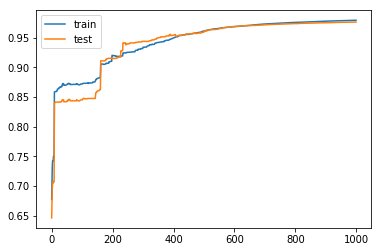

In [90]:
plt.plot(model.evals_result_['validation_0']['auc'],label='train')
plt.plot(model.evals_result_['validation_1']['auc'],label='test')
plt.legend(loc='upper left')
plt.show()

Since we have imbalanced dataset, we evaluate model performance based on auc-roc not error

#### after find best number of tree, start to fine tune for tree structure params

In [ ]:
params = {'learning_rate': 0.1, 'n_estimators': 600, 
         'max_depth': [3,5,7,9], 'colsample_bytree':0.4,
         'objective': 'binary:logistic', 
         }

#### after finding best values for trees, now start to fine tune to find learning-rate

### Adding unique sites# for each session

In [24]:
sites = ['site%d' %i for i in range(1,11)]
times = ['time%d' %i for i in range(1,11)]
train_df = pd.read_csv('train_sessions.csv',index_col='session_id', parse_dates=times)
test_df = pd.read_csv('test_sessions.csv', index_col='session_id', parse_dates=times)

train_df = train_df.sort_values(by='time1')

# clean data 
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [32]:
# Let's see what is most freq website of Alice use
Alice_df = train_df[train_df['target']==1]
other_df = train_df[train_df['target']==0]
top_sites_alice = pd.Series(Alice_df[sites].values.flatten()).value_counts().drop(labels=[0]).sort_values(ascending=False).head(20)
top_sites_other = pd.Series(other_df[sites].values.flatten()).value_counts().drop(labels=[0]).sort_values(ascending=False).head(20)

def uniq_count(x):
    uniq_array = np.unique(x)
    uniq_ct = len(uniq_array)
    if 0 in uniq_array:
        uniq_ct-=1
    return uniq_ct


train_uniq_session = train_df[sites].apply(uniq_count, axis=1).values.reshape(-1,1) # without NaN sites
test_uniq_session = test_df[sites].apply(uniq_count, axis=1).values.reshape(-1,1)
train_uniq_session = scaler.fit_transform(train_uniq_session)
test_uniq_session = scaler.transform(test_uniq_session)

new_train_adduniq = hstack([new_train_addYMD, train_uniq_session])
new_test_adduniq = hstack([new_test_addYMD, test_uniq_session])

C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
new_features2+=['unique']

In [31]:
logit_new = LogisticRegression(C=1.0, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100)
cv_add_YMD_feat = train_and_predict(logit_new, new_train_adduniq, y_train, new_test_adduniq, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv')


CV ROC Score->[0.77019893 0.81615594 0.94529484 0.963903   0.91676763 0.95975906
 mean: 0.917981993794205, std: 0.06511581813691804


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+5.160,youwatch.org
+5.007,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.993,vk.com
+4.969,www.express.co.uk
+4.707,www.info-jeunes.net
+4.437,www.melty.fr
+4.400,www.audienceinsights.net
+4.392,fr.glee.wikia.com
+4.021,www.banque-chalus.fr
+3.929,api.bing.com


### Adding site# each session have based on alice_top20_unique (different with other_top20_unique)

In [42]:
alice_uniq_top = set(alice_top20) - set(other_top20)

In [44]:
# add top 20 alice website 
alice_top20 = list(top_sites_alice.index)
alice_top20.sort()
other_top20 = list(top_sites_other.index)
other_top20.sort()

def have_top20_alice_sites(x, top20_sites):
    uniq_session = set(np.unique(x))
    have_top20_cnt = list(set(top20_sites) & uniq_session)
    return len(have_top20_cnt)

train_have_top20 = train_df[sites].apply(have_top20_alice_sites, top20_sites=alice_uniq_top, axis=1).values.reshape(-1,1)
test_have_top20 = test_df[sites].apply(have_top20_alice_sites, top20_sites=alice_uniq_top, axis=1).values.reshape(-1,1)
# train_have_top20 = scaler.fit_transform(train_have_top20)
# test_have_top20 = scaler.transform(test_have_top20)

new_train_addtop20 = hstack([new_train_adduniq, train_have_top20])
new_test_addtop20 = hstack([new_test_adduniq, test_have_top20])

In [35]:
new_features2+=['Have_top20_alice']

In [45]:
logit_new = LogisticRegression(C=4.6415888336127775, random_state=17, n_jobs=-1, solver='liblinear', max_iter=100, penalty='l2')
cv_add_YMD_feat = train_and_predict(logit_new, new_train_addtop20, y_train, new_test_addtop20, site_features=tfv.get_feature_names(), new_feature_names=new_features2,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv')

CV ROC Score->[0.78752551 0.80324791 0.95083693 0.97234163 0.91968064 0.95648644
 mean: 0.921396302070578, std: 0.0645906936074649


C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Weight?,Feature
+11.721,www.express.co.uk
+11.364,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.909,tru.am
+7.105,browser-update.org
+6.487,fr.glee.wikia.com
+6.307,api.bing.com
+6.288,www.banque-chalus.fr
+6.195,glee.hypnoweb.net
+6.017,mcetv.fr
+5.889,www.springboardplatform.com


## grid search 

In [44]:
logit = LogisticRegression(random_state=17, solver='liblinear')
params = {
    'penalty':['l1','l2'],
    'C': np.logspace(-2,2,10)
}

grid = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', cv=time_split, verbose=1, n_jobs=-1)
grid.fit(new_train_addtop20, y_train)
grid.best_estimator_, grid.best_score_, grid.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 48.6min finished


(LogisticRegression(C=4.6415888336127775, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 0.9218592784620138,
 {'C': 4.6415888336127775, 'penalty': 'l2'})

## Xgboost model

In [91]:
xgb = XGBClassifier(slient=False,
                     scale_pos_weight=1,
                     learning_rate=0.01,
                     colsample_bytree=0.4,
                     subsample=0.8,
                     objective='binary:logistic',
                     n_estimators=1000,
                     reg_alpha=0.3,
                     max_depth=4,
                     gamma=10)


In [93]:
xgb.fit(new_train_addYMD, y_train,eval_metric='auc')


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=10,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, slient=False, subsample=0.8, verbosity=1)

In [94]:
test_pred = xgb.predict_proba(new_test_addYMD)[:,-1]
write_to_submission_file(test_pred, out_file='submission_xgb.csv')

In [35]:
test_pred

array([0.00028554, 0.00016251, 0.00201537, ..., 0.00023464, 0.00025884,
       0.00026675], dtype=float32)

## Add YMD as Categorical Feature
### 93.8%

In [317]:
train_weekday_feat = train_times['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
train_yearmonth_feat = (train_times['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
train_month_feat = train_times['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)

test_weekday_feat = test_times['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
test_yearmonth_feat = (test_times['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
test_month_feat = test_times['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)

In [368]:
weekday_train = train_times['time1'].apply(lambda ts: ts.weekday()).values.astype(str)
weekday_test = test_times['time1'].apply(lambda ts: ts.weekday()).values.astype(str)

from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
train_week = one_hot.fit_transform(weekday_train.reshape(-1,1))
test_week = one_hot.transform(weekday_test.reshape(-1,1))

C:\Users\900309\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [369]:
month_map = {'1': 'Jan.', '2': 'Feb.', '3': 'Mar.', '4': 'Apr', '5': 'May', '6': 'Jun', '7': 'Jul', '8': 'Aug',
            '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
month_train = train_times['time1'].apply(lambda ts: month_map[str(ts.month)]).values.reshape(-1,1)
month_test = test_times['time1'].apply(lambda ts: month_map[str(ts.month)]).values.reshape(-1,1)
train_month = one_hot.fit_transform(month_train)
test_month = one_hot.transform(month_test)

In [378]:
new_train_wYMD_cate = hstack([new_train_wdur,train_week, train_yearmonth_feat ,train_month]) 
new_test_wYMD_cate = hstack([new_test_wdur, test_week, test_yearmonth_feat ,test_month])

In [384]:
new_features3 = new_features2[:5].copy()
new_features3+=['%d' %i for i in range(1,8)]
new_features3+=['yearmonth']
new_features3+=[month_map[i] for i in month_map]

In [409]:
logit_higher_iter = LogisticRegression(random_state=17, C=4, max_iter=100, solver='lbfgs',n_jobs=-1)
cv_add_YMD_cate_feat = train_and_predict(logit_higher_iter, new_train_wYMD_cate, y_train, new_test_wYMD_cate, site_features=tfv.get_feature_names(), new_feature_names=new_features3,
                     cv=time_split, scoring='roc_auc', top_n_features=30, submission_file='submission.csv')

CV ROC Score->[0.85480942 0.90263939 0.86556446 0.98159654 0.85981031 0.9729935
 mean: 0.9147159707392566, std: 0.05272820462163403


Weight?,Feature
+10.304,www.express.co.uk
+10.013,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.286,vk.com
+7.213,www.banque-chalus.fr
+6.997,fr.glee.wikia.com
+6.708,www.video.tt
+6.501,api.bing.com
+6.401,browser-update.org
+6.388,www.clermont-filmfest.com
+6.230,tru.am


In [401]:
pd.DataFrame({'feat_name': new_features3, 'coef': logit_higher_iter.coef_[0][-len(new_features3):]})

,feat_name,coef
0,morning,-1.545675
1,day,2.181304
2,evening,-1.733231
3,night,0.000000
4,duration time,-0.301149
5,1,1.727957
6,2,0.793391
7,3,-2.016471
8,4,-0.781472
9,5,0.349274
